# Lab 3: Visualizing nonlinear regression

Data science is a visual practice. Visualizing your models and their prediction (and their errors) so that you can communicate findings and limitations well is 50% of the job.

We will recreate much of the models shown in class. First load and look through the motorcycle dataset.

In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('motorcycle.csv')
print(df)

     times  accel
0      2.4    0.0
1      2.6   -1.3
2      3.2   -2.7
3      3.6    0.0
4      4.0   -2.7
..     ...    ...
128   53.2  -14.7
129   55.0   -2.7
130   55.0   10.7
131   55.4   -2.7
132   57.6   10.7

[133 rows x 2 columns]


The dataset column 'times' is the time since impact and 'accel' is the acceleration of the rider's head in g (gravitational force).

The dataset has some duplicated times, and without a way to really interpret what those mean, we should remove them as some methods do not really deal with those well. The following line removes any entries with duplicated 'times' values (keeping only the first to appear).

In [90]:
df = df[~ df['times'].duplicated()]

Now we can plot

<Axes: xlabel='times', ylabel='accel'>

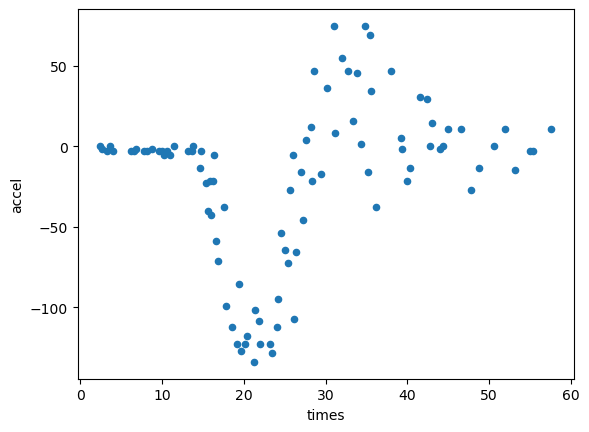

In [91]:
df.plot.scatter(x='times', y='accel')

## Polynomial regression

The first model to fit is polynomial regression. You saw in lecture that polynomial regression (like all basis expansion methods) are simply fit by linear regression with an appropriately constructed basis. 

### Problem 1
Use the method 'sklearn.preprocessing.PolynomialFeatures' to construct those bases and fit a few different polynomials of differing degrees and plot them to compare.

/Users/tianhaoyao/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


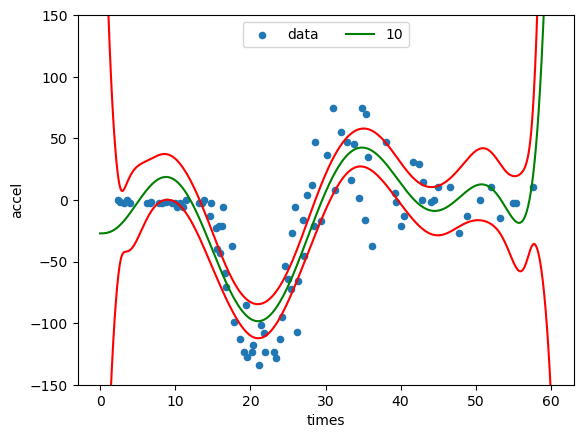

In [92]:
"""
The import statements below are to help you. If you read the documentation, you will see PolynomialFeatures
is used like this:

    pr = PolynomialFeatures(degree=3)  # for a degree 3 polynomial
    X_polynomial = pr.fit_transform(X)
    
Note that, even though we are only dealing with univariate inputs, most scikit-learn routines expect a 2-D matrix
to make predictions.

For a column of a dataframe, you can make sure you have that by doing:

    X = df['times'].to_frame()
    
Or for a numpy array, you can use

    x_line = np.linspace(0, 60, 1000)  # this is just a 1-D array of shape (1000,)
    x_line_2d = x_line.reshape(-1, 1)  # this is now a 2-D array of shape (1000, 1)
    
"""

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

df.plot.scatter(x='times', y='accel')

degrees = [3, 5, 10, 20]
degrees = [10]
colors = ['g', 'r', 'c', 'm']

for i_ in range(len(degrees)):
    
    degree = degrees[i_]
    color = colors[i_]

    lr = LinearRegression()
    pr = PolynomialFeatures(degree=degree)

    X = df['times'].to_frame()
    Y = df['accel']
    
#     print(X)
    X_poly = pr.fit_transform(X)
#     print(X_poly)
#     X_poly = X_poly[:, 1:]
#     print(X_poly.shape)
    lr.fit(X_poly[:, 1:], Y)
#     print(lr.coef_)
#     print(lr.intercept_)
    Y_pred = lr.predict(X_poly[:, 1:])
    residuals = Y_pred - Y

    sigma_squared = np.sum(residuals**2) / (len(Y) - len(lr.coef_) - 1)

#     X_poly_w_intercept = np.c_[np.ones((X_poly.shape[0], 1)), X_poly]  # add intercept
#     print(X_poly_w_intercept)
    var_covar_mat = np.linalg.inv(X_poly.T @ X_poly) * sigma_squared

    x_line = np.linspace(0, 60, 1000)
#     print(x_line)
    x_line_poly = pr.transform(x_line.reshape(-1, 1))
#     print(x_line.reshape(-1, 1))
#     print(x_line_poly.shape)
#     x_line_poly = x_line_poly[:, 1:]
#     print(x_line_poly.shape)
    y_line = lr.predict(x_line_poly[:, 1:])
    y_hi, y_lo = [], []
    for i in range(len(x_line)):
        y_hi.append(y_line[i] + 1.96*np.sqrt(x_line_poly[i].T @ var_covar_mat @ x_line_poly[i]))
        y_lo.append(y_line[i] - 1.96*np.sqrt(x_line_poly[i].T @ var_covar_mat @ x_line_poly[i]))

    plt.plot(x_line, y_line, color=color)
    plt.plot(x_line, y_hi, color="r")
    plt.plot(x_line, y_lo, color="r")

    plt.ylim(-150, 150)

# print(X_poly)
plt.legend(['data'] + degrees, ncol=5)

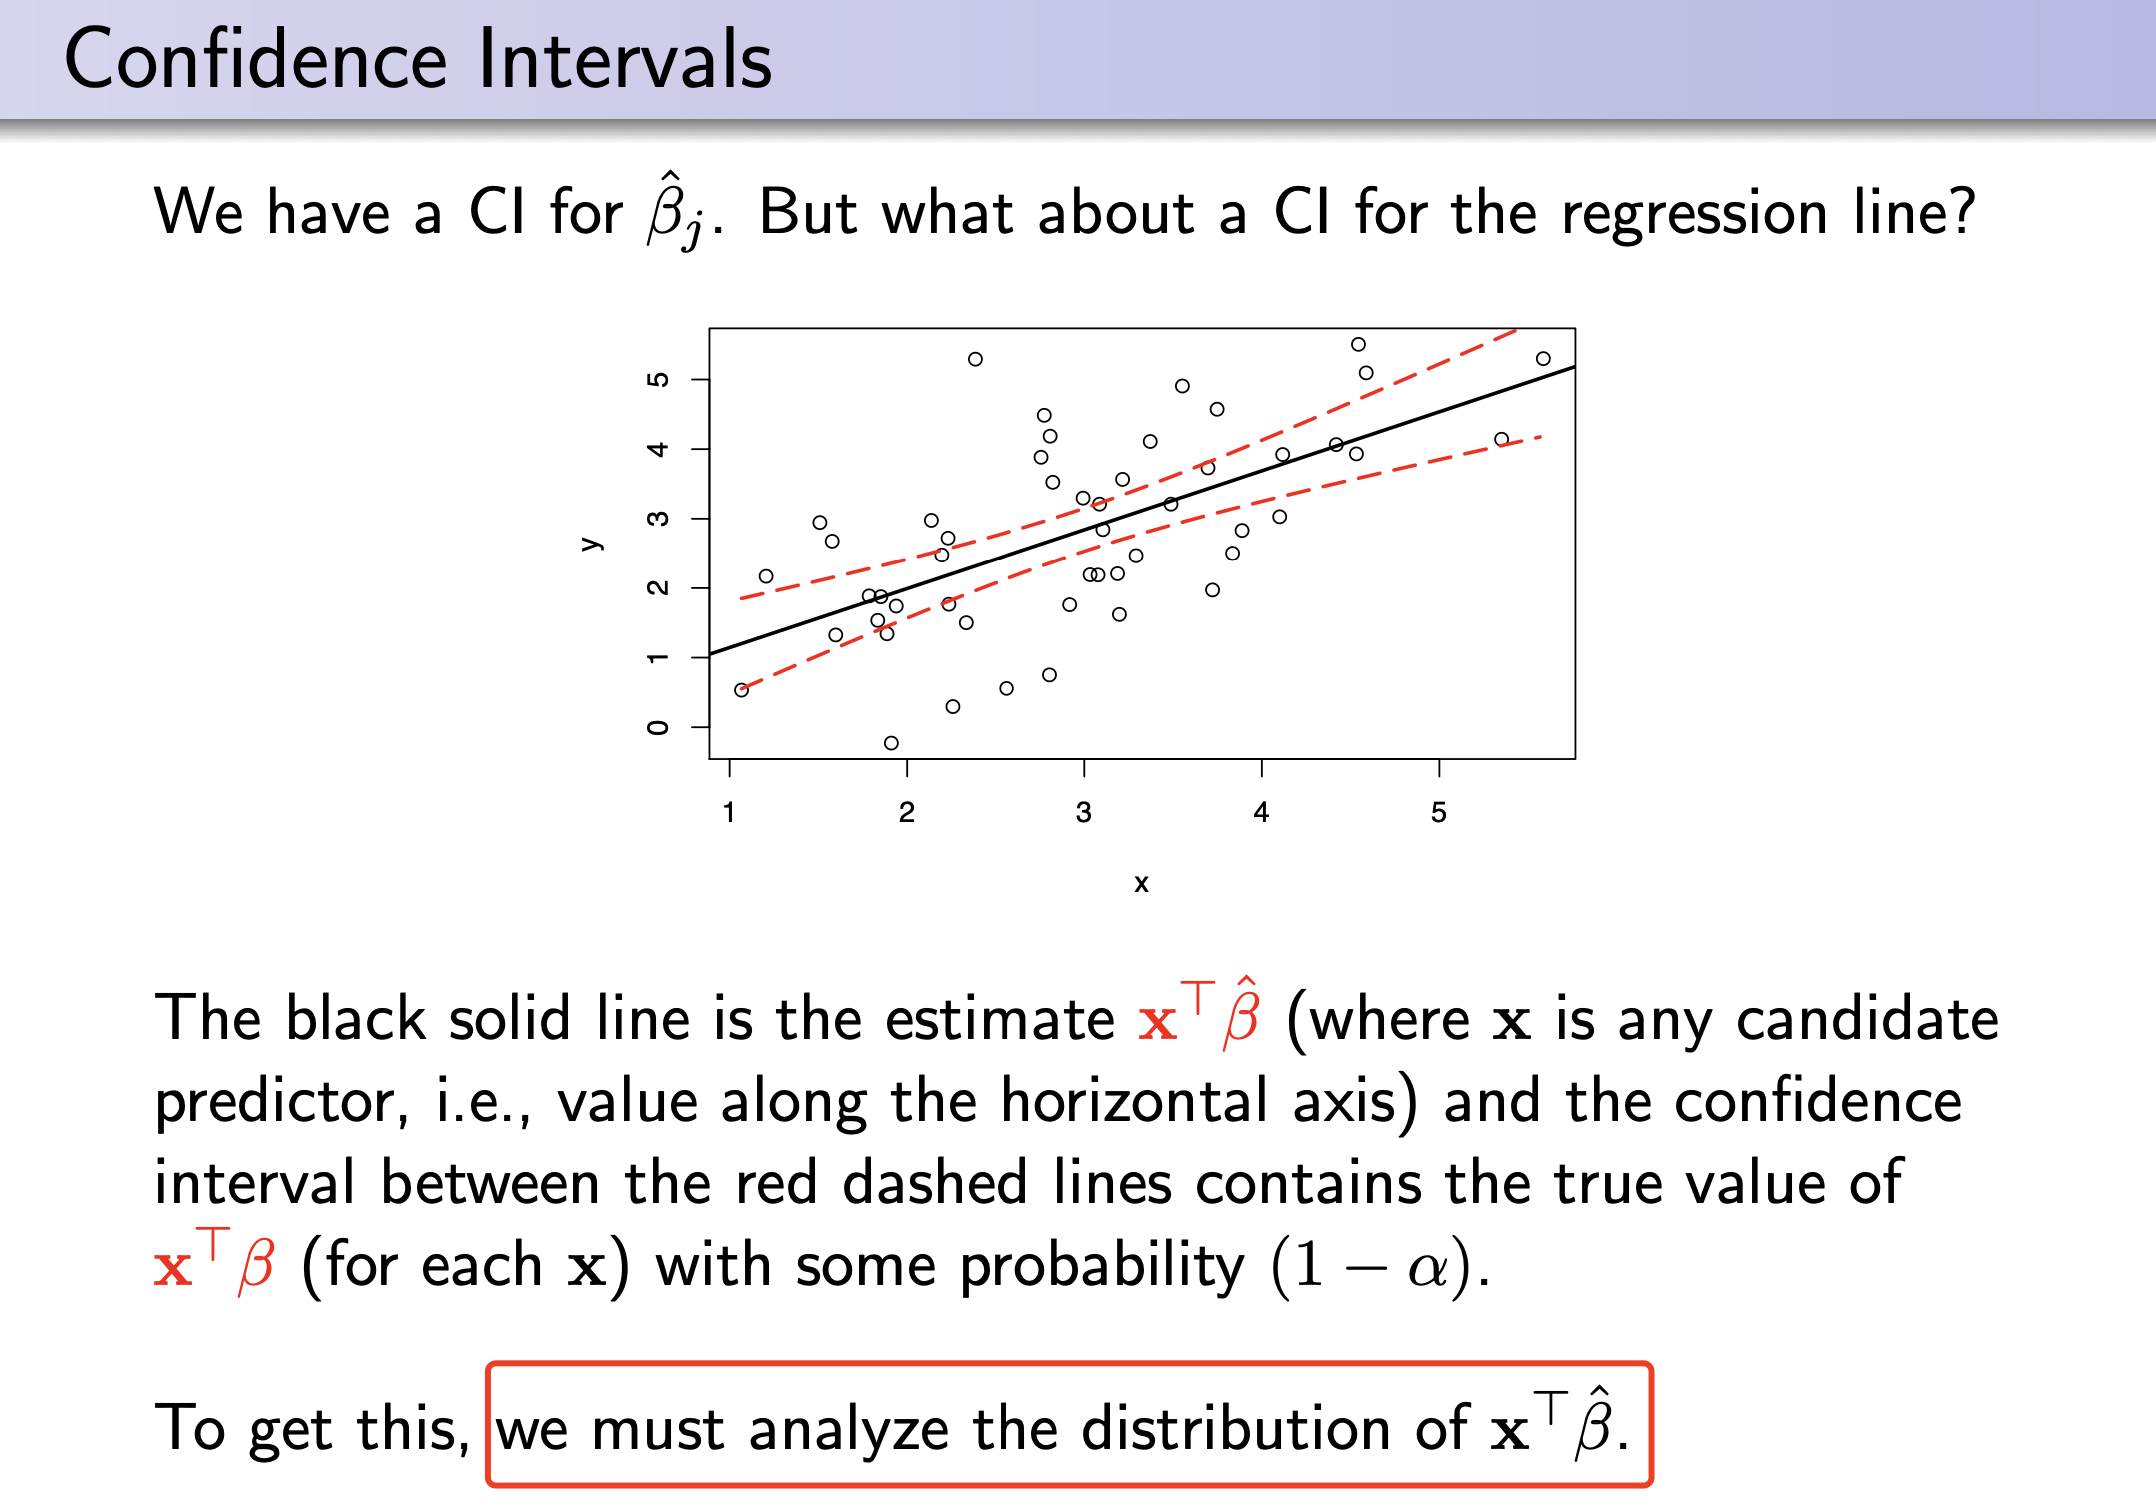
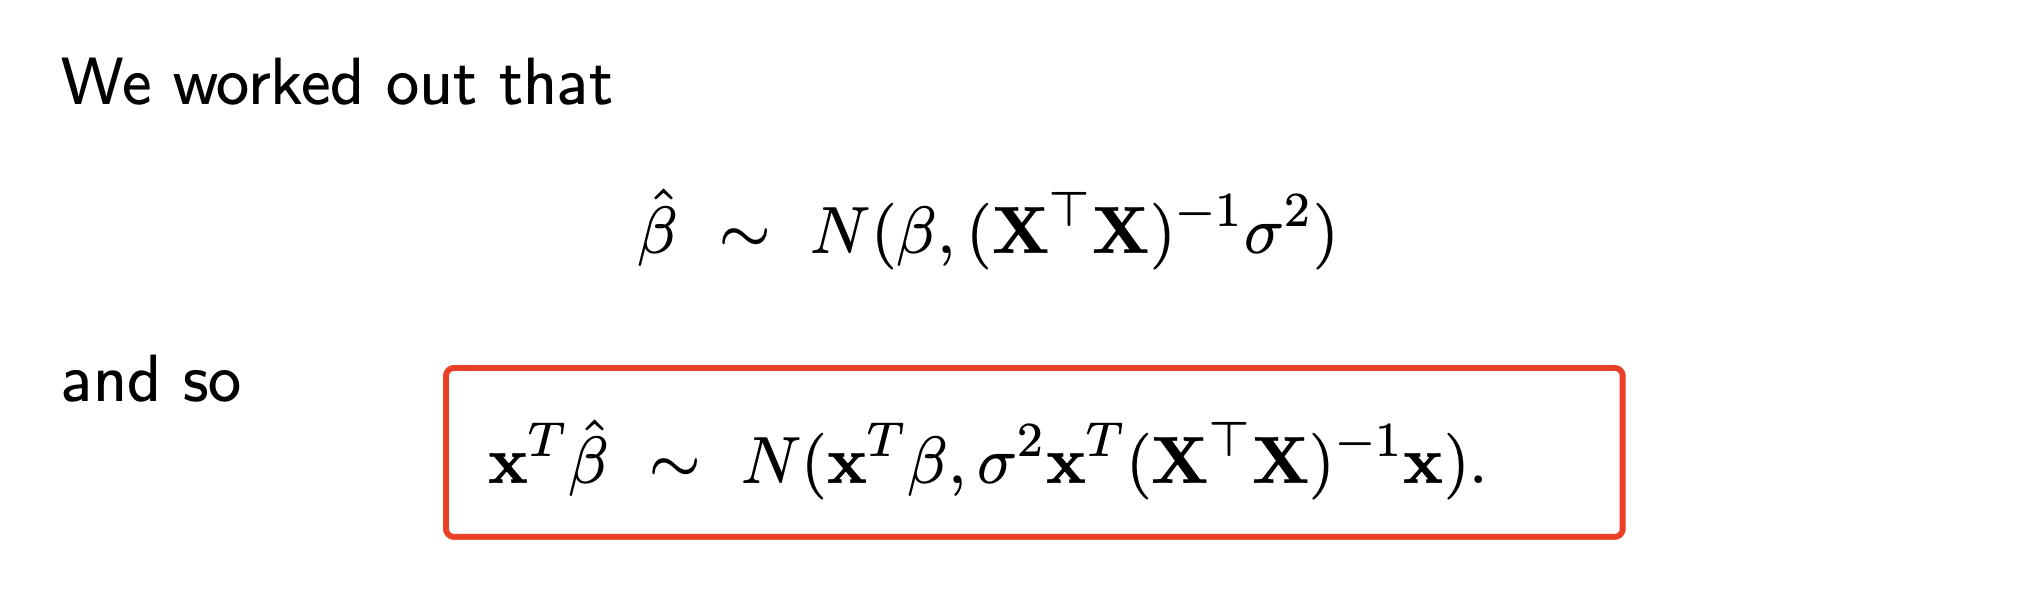
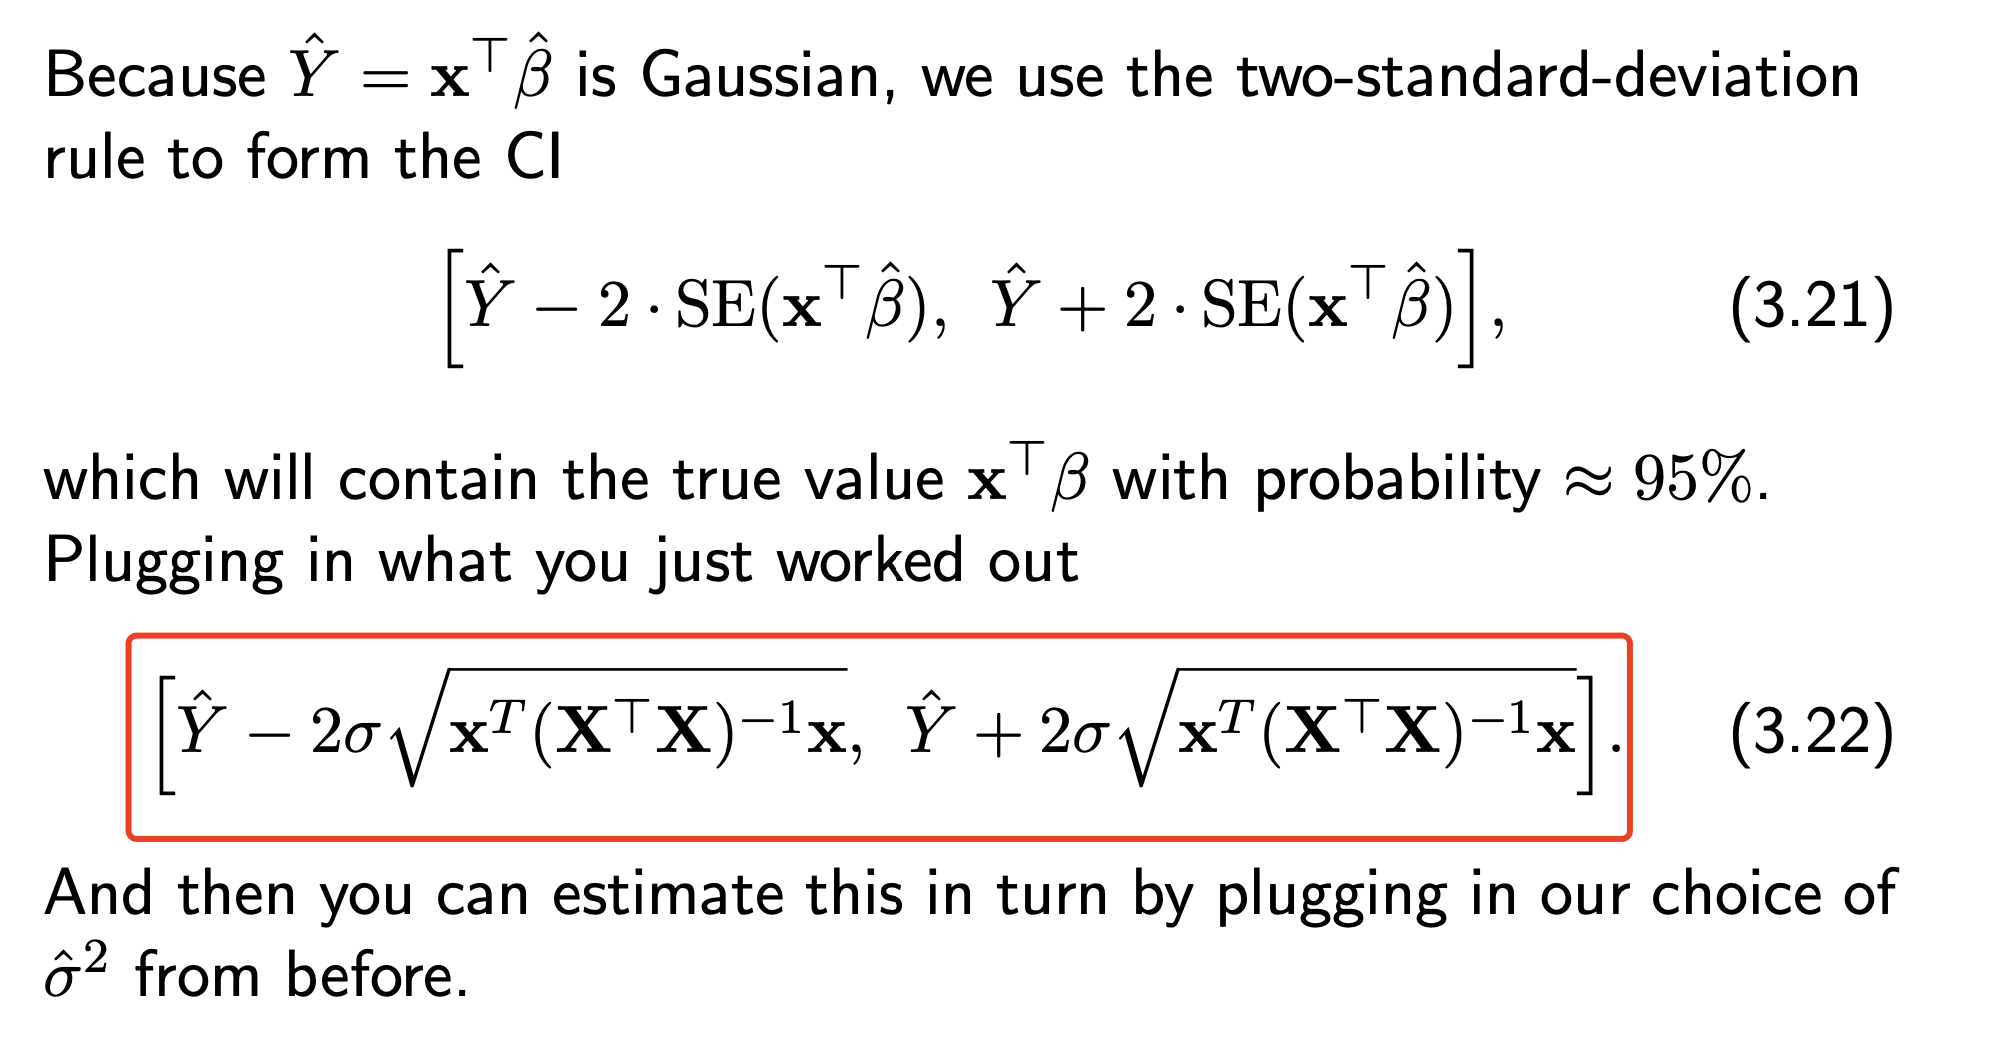

For polynomial regression, it would just need to be:
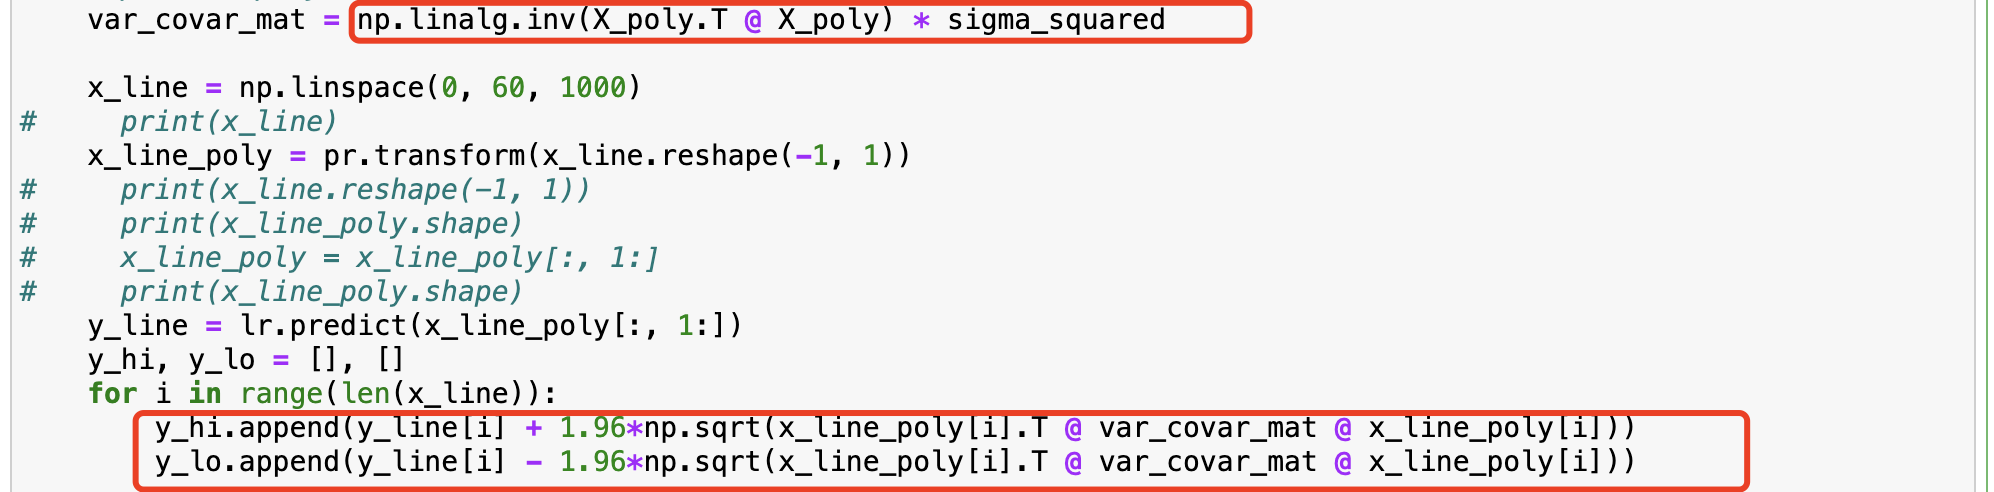

X_line_poly[i]^T @ (X_poly^T @ X)^(-1) @ X_line_poly[i]

## Regression splines

It is better to use (natural) cubic regression splines. These are the most popular of all regression splines used in practice. scipy (a scientific programming package that is similar to Numpy and Pandas and is built-in to most Python distributions) has a method 'scipy.interpolate.UnivariateSpline' for natural cubic regression splines.

### Problem 2
Fit a natural cubic regression spline with various regularization parameters, which are called 's' in the method.

Text(0.5, 1.0, 'lambda = 500 x n')

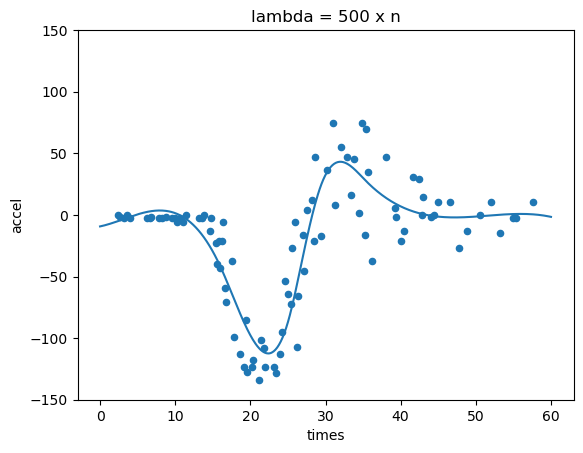

In [84]:
"""
After importing, you create and fit the model like:

    s = 100 * len(X)  # the regularization parameter... you can play around with different values
    spl = UnivariateSpline(X, Y, s=s)
    y_pred = spl(x_test)  # to make predictions. Here x_test can be a 1-D array.
    
"""

from scipy.interpolate import UnivariateSpline, InterpolatedUnivariateSpline

X = df['times']
Y = df['accel']

alpha = 500
spl = UnivariateSpline(X, Y, s=alpha*len(X))

x_line = np.linspace(0, 60, 500)
y_line = spl(x_line)

df.plot.scatter(x='times', y='accel')
plt.plot(x_line, y_line)
plt.ylim(-150, 150)
plt.title('lambda = %d x n' % alpha)

The natural next step is to choose a good value for the penalty parameter via cross validation. Because this is a relatively small dataset, we probably want to use K-fold cross validation, which uses up as much of the data as possible.

We can not use the cross-validation helper introduced in Lab 2 (last week) so easily, because we are not using a scikit-learn model to for the smoothing spline. So instead we can use another scikit-learn cross-validation helper for K-fold cross-validation: 'sklearn.model_selection.KFold'.

### Problem 3
Use cross-validation to select a good value of the penalization parameter for the smoothing spline.

In [62]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=10)  # K-fold cross validation

for train_index, test_index in kf.split(X):
    print(train_index)
    print(test_index)

alphas = [1, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700]
cv_scores = {}  # to keep track of the CV score for each value of alpha
for alpha in alphas:
    
    scores = []  # to collect up the scores across the splits
    for train_index, test_index in kf.split(X):
        
        X_train = X.iloc[train_index]
        X_test = X.iloc[test_index]
        
        Y_train = Y.iloc[train_index]
        Y_test = Y.iloc[test_index]
    
        spl = UnivariateSpline(X_train, Y_train, s=alpha*len(X_train))
        Y_pred = spl(X_test)
        
        rmse = np.sqrt(np.mean((Y_test - Y_pred)**2))
        scores.append(rmse)
        
    cv_scores[alpha] = scores  # take the average over the CV folds

cv_scores_df = pd.DataFrame(cv_scores)
print(cv_scores_df)

[10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33
 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57
 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81
 82 83 84 85 86 87 88 89 90 91 92 93]
[0 1 2 3 4 5 6 7 8 9]
[ 0  1  2  3  4  5  6  7  8  9 20 21 22 23 24 25 26 27 28 29 30 31 32 33
 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57
 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81
 82 83 84 85 86 87 88 89 90 91 92 93]
[10 11 12 13 14 15 16 17 18 19]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 30 31 32 33
 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57
 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81
 82 83 84 85 86 87 88 89 90 91 92 93]
[20 21 22 23 24 25 26 27 28 29]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 

Text(0, 0.5, 'root mean squared error')

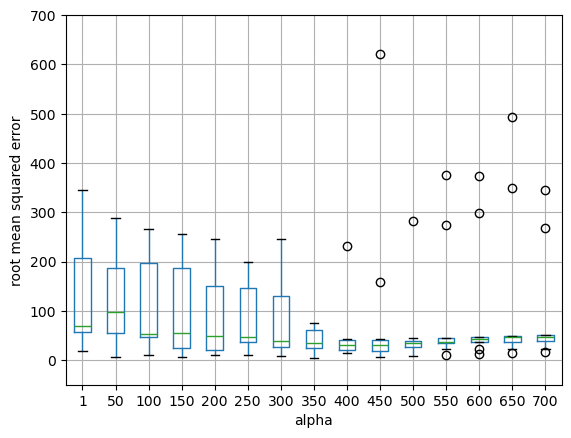

In [63]:
cv_scores_df.boxplot()
plt.ylim(-50, 700)
plt.xlabel('alpha')
plt.ylabel('root mean squared error')

In [64]:
#print(cv_scores_df.mean())
print(cv_scores_df.mean().sort_values())  # if we want to choose based on the best mean over the folds

print(cv_scores_df.median().sort_values())  # or based on the best median over the folds

500      55.257468
550      91.495369
700      92.630188
600      95.574349
450      97.676712
650     114.808213
400     256.130727
350     370.607964
150    1256.607616
100    1265.424948
250    1266.540876
300    1267.414580
50     1267.707017
200    1278.701200
1      4713.267027
dtype: float64
450    29.712260
400    30.902131
350    34.609001
500    34.902314
550    37.521467
300    37.735772
600    41.823708
700    46.523080
650    46.853438
250    47.821367
200    48.525368
100    53.103485
150    54.750542
1      68.505668
50     96.695961
dtype: float64


### Solution
It seems s=500 * len(X) or s=450 * len(X) have the best fit, depending on whether you judge by the mean or median of the cross validation scores. Let us visualize those two.

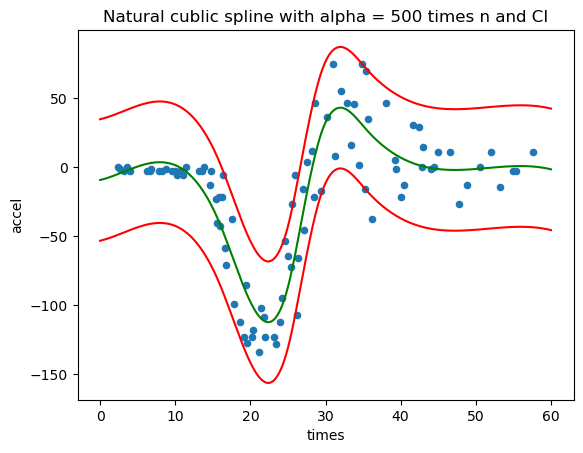

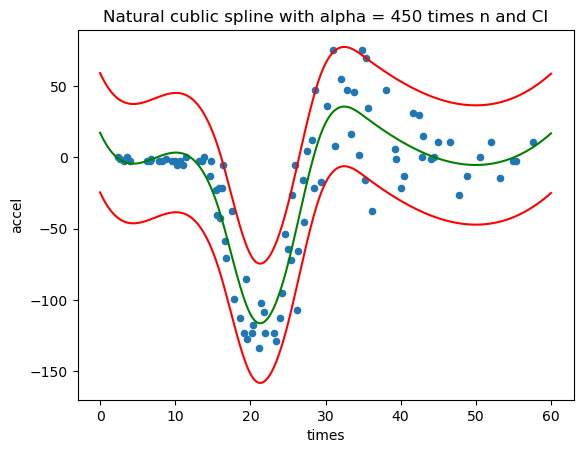

In [104]:
x_line = np.linspace(0, 60, 500)
alphas = [500, 450]

for alpha in alphas:
    spl = UnivariateSpline(X, Y, s=alpha*len(X))
    y_line = spl(x_line)
#     print(len(spl.get_coeffs()))
#     print(spl.get_coeffs())
#     print(len(spl.get_knots()))
#     print(spl.get_knots())

    Y_pred = spl(X["times"])
#     print(Y)
#     print(Y_pred)
    std = np.sqrt(np.var(Y-Y_pred, ddof=1))
    y_hi, y_lo = [], []
    for i in range(len(x_line)):
        y_hi.append(y_line[i] + 1.96*std)
        y_lo.append(y_line[i] - 1.96*std)

    df.plot.scatter(x='times', y='accel')
    plt.title(f"Natural cublic spline with alpha = {alpha} times n and CI")
    plt.plot(x_line, y_line, color='g')
    plt.plot(x_line, y_hi, color="r")
    plt.plot(x_line, y_lo, color="r")
    plt.show()